## Comparision LSTM vs MLP and normalising flow vs ddpm
This notebook compares the differences between various approaches for a selected dataset.
We execute 3 experiments:
1. LSTM vs MLP using the original node+normalised graphsage embedding as input. This shows the potential of synthesing realistic edges.
2. LSTM vs MLP using nodes and embedding synthesized with the DDPM algo. This shows compared to experiment 1, the cost of using synthetic nodes.
3. LSTM vs MLP using nodes and embedding synthesized with the normalising flows algo

In [1]:
# Set root dir
import os
os.chdir('..')
print(os.getcwd())

/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj


In [2]:
# import modules
import pickle
from tigger_package.orchestrator import Orchestrator
from tigger_package.metrics.distribution_metrics import NodeDistributionMetrics, EdgeDistributionMetrics
from tigger_package.tools import plot_adj_matrix, plot_hist
import networkx as nx 
import pandas as pd
import time


loaded


In [5]:
#dataset folder and load orchestrator
folder = "data/erdos/"
orchestrator = Orchestrator(folder)
# orchestrator.create_graphsage_embedding()


In [4]:
def compare_metrics(nodes, edges, synth_nodes, synth_edges, name):
    ndm = NodeDistributionMetrics(nodes, synth_nodes)
    node_metric_df = ndm.calculate_wasserstein_distance()
    
    # edge atributes
    edm = EdgeDistributionMetrics(edges, synth_edges)
    edge_metrec_df = edm.calculate_wasserstein_distance()
    
    degree_metric_df = edm.get_degree_wasserstein_distance()
    _, widget_delta_df = edm.widgets_distr()
    cc_df = edm.clustering_coef_undirected()
    
    results = pd.concat([node_metric_df,edge_metrec_df,degree_metric_df, cc_df], axis=0)
    results = results.reset_index(names='name')
    results = results.rename(columns={"value": name})
    return results

# Experiment 1 LSTM vs MLP  Orig datasat

In [4]:
# create "dummy" synth dataset that is equal to the original dataset.
embed = orchestrator._load_normalized_embed()
node = orchestrator._load_nodes()
tmp = pd.concat([embed, node], axis=1)
tmp.to_parquet(folder + "synth_node_orig.parquet")

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/99549 [00:00<?, ?it/s]

Number of components, 130


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

 7680 / 8000, epoch:99 loss=4.620706081390381, val_loss: 5.0642509460449229

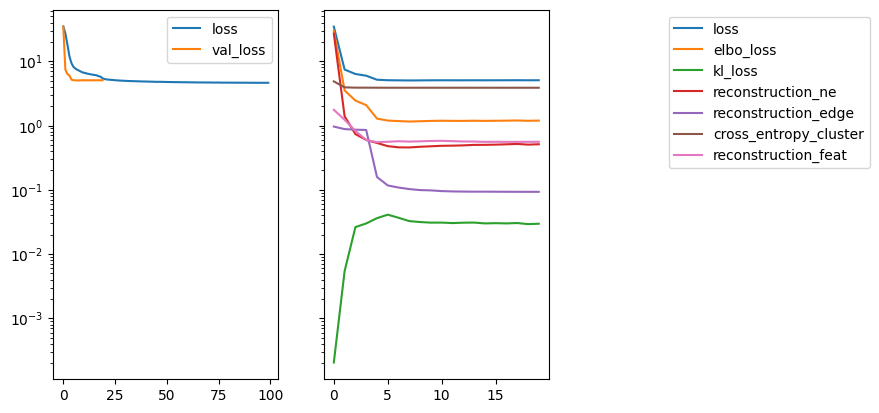

In [5]:
#train LSTM and sample edges
loss_dict = orchestrator.train_lstm()
orchestrator.create_synthetic_walks(
    synthesizer=orchestrator.lstm_controller,
    target_cnt=100000, synth_node_file_name=folder + "synth_node_orig.parquet", map_real_time=False
)

# rename synth walks
obj = pickle.load(open(folder + 'synth_walks.pickle', 'rb'))
pickle.dump(obj, open(folder + 'synth_walks_lstm.pickle', 'wb'))

# create synth graph
orchestrator.generate_synth_graph(synth_nodes_name = folder + "synth_node_orig.parquet")
tmp = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
tmp.to_parquet(folder + 'synth_graph/node_attributes_lstm.parquet')
tmp = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
tmp.to_parquet(folder + 'synth_graph/adjacency_lstm.parquet')

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 epoch 100/100 train loss 4.766070783138275 val loss: 4.7657209873199475

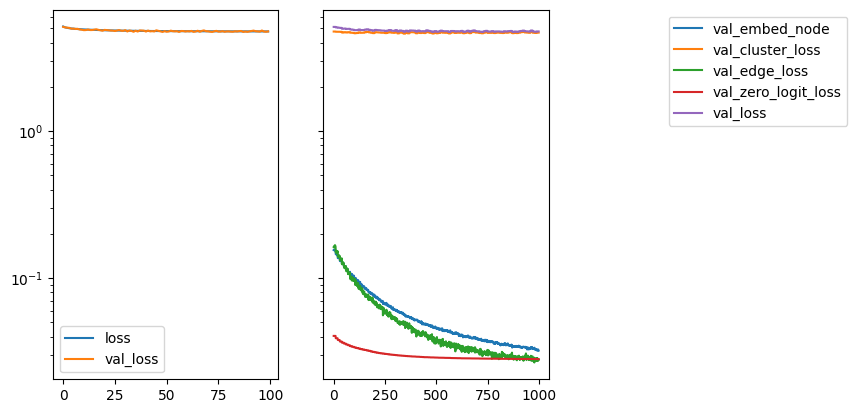

In [6]:
#train MLP and sample edges
loss_dict = orchestrator.train_graphsyntesizer2()
orchestrator.create_synthetic_walks(
    synthesizer=orchestrator.graphsynthesizer2,
    target_cnt=200000, synth_node_file_name=folder + "synth_node_orig.parquet", map_real_time=False
)

# rename synth walks
obj = pickle.load(open(folder + 'synth_walks.pickle', 'rb'))
pickle.dump(obj, open(folder + 'synth_walks_mlp.pickle', 'wb'))

# create synth graph
orchestrator.generate_synth_graph(synth_nodes_name = folder + "synth_node_orig.parquet")
tmp = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
tmp.to_parquet(folder + 'synth_graph/node_attributes_mlp.parquet')
tmp = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
tmp.to_parquet(folder + 'synth_graph/adjacency_mlp.parquet')

LSTM: orig has (99549, 9) format and synth edges (70855, 9)
MLP: orig has (99549, 9) format and synth edges (100000, 9)


/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/metrics/distribution_metrics.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/metrics/distribution_metrics.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,type,metric,name,LSTM,MLP
0,node_attributes,Wasserstein_distance,attr0,0.000000,0.000000
1,node_attributes,Wasserstein_distance,attr1,0.000000,0.000000
2,node_attributes,Wasserstein_distance,attr2,0.000000,0.000000
3,node_attributes,Wasserstein_distance,attr3,0.000000,0.000000
4,node_attributes,Wasserstein_distance,attr4,0.000000,0.000000
5,node_attributes,Wasserstein_distance,attr5,0.000000,0.000000
6,node_attributes,Wasserstein_distance,attr6,0.000000,0.000000
7,node_attributes,Wasserstein_distance,attr7,0.000000,0.000000
8,edge_attributes,Wasserstein_distance,edge_att0,0.092934,0.031330
9,edge_attributes,Wasserstein_distance,edge_att1,0.096678,0.009615


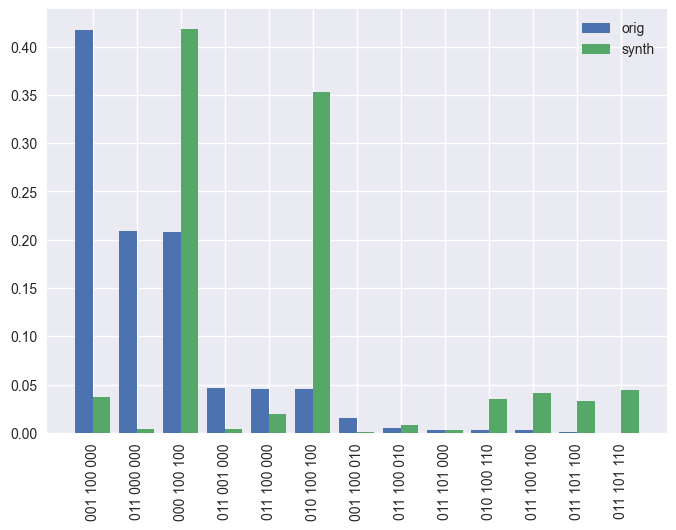

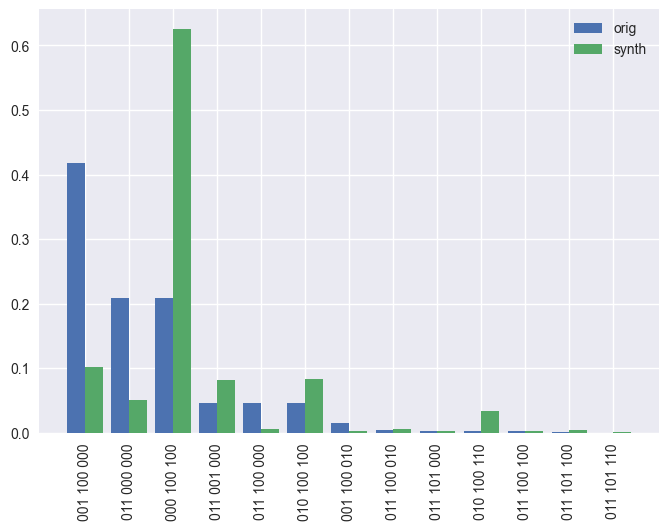

In [4]:
#assess quality of synthegraph
nodes = orchestrator._load_nodes()
edges = orchestrator._load_edges()
lstm_nodes = pd.read_parquet(folder + 'synth_graph/node_attributes_lstm.parquet')
lstm_edges = pd.read_parquet(folder + 'synth_graph/adjacency_lstm.parquet')
print(f"LSTM: orig has {edges.shape} format and synth edges {lstm_edges.shape}")
mlp_nodes = pd.read_parquet(folder + 'synth_graph/node_attributes_mlp.parquet')
mlp_edges = pd.read_parquet(folder + 'synth_graph/adjacency_mlp.parquet')
print(f"MLP: orig has {edges.shape} format and synth edges {mlp_edges.shape}")  
 
def compare_metrics(nodes, edges, synth_nodes, synth_edges, name):
    ndm = NodeDistributionMetrics(nodes, synth_nodes)
    node_metric_df = ndm.calculate_wasserstein_distance()
    
    # edge atributes
    edm = EdgeDistributionMetrics(edges, synth_edges)
    edge_metrec_df = edm.calculate_wasserstein_distance()
    
    degree_metric_df = edm.get_degree_wasserstein_distance()
    _, widget_delta_df = edm.widgets_distr()
    cc_df = edm.clustering_coef_undirected()
    
    results = pd.concat([node_metric_df,edge_metrec_df,degree_metric_df, cc_df], axis=0)
    results = results.reset_index(names='name')
    results = results.rename(columns={"value": name})
    return results

lstm_results = compare_metrics(nodes, edges, lstm_nodes, lstm_edges, "LSTM")
mlp_results = compare_metrics(nodes, edges, mlp_nodes, mlp_edges, "MLP")
results = lstm_results.merge(mlp_results, on=['name', 'type', 'metric'])
results[['type', 'metric', 'name', 'LSTM', 'MLP']]

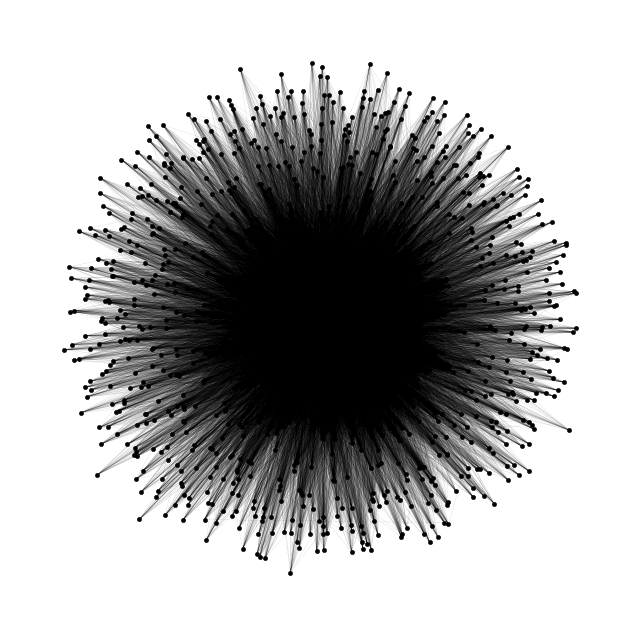

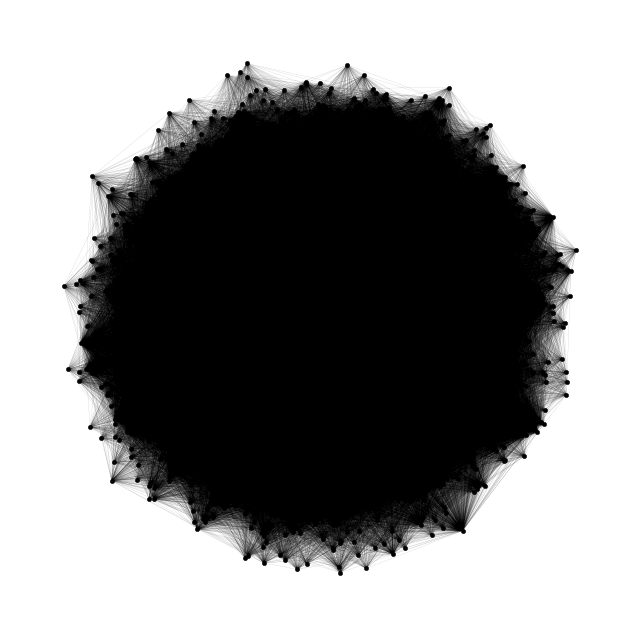

In [8]:
#plot graphs
plot_adj_matrix(lstm_edges)
plot_adj_matrix(mlp_edges)

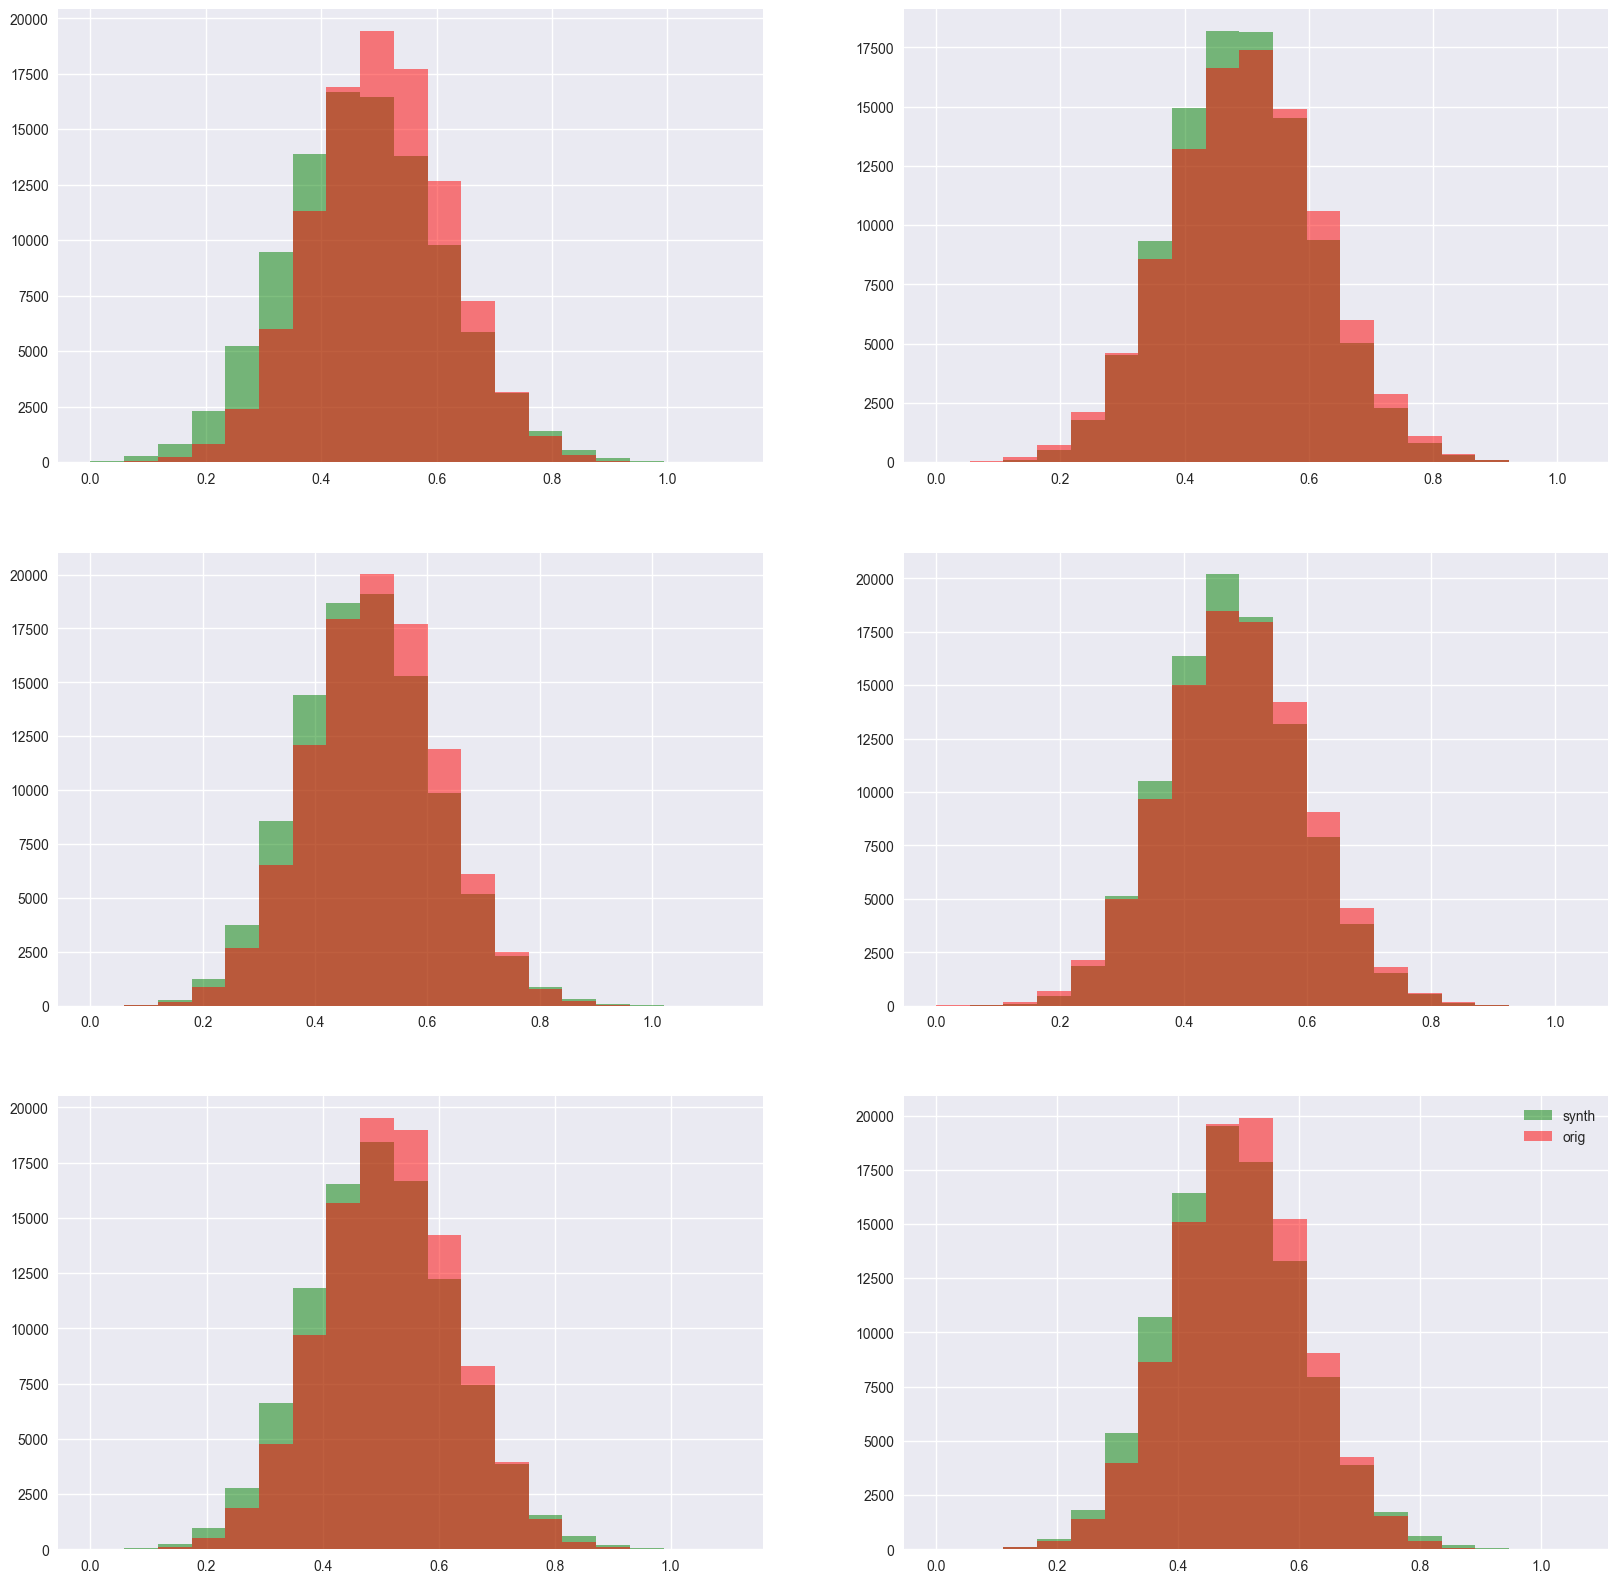

In [18]:
from tigger_package.tools import plot_hist 
plot_hist(edges.drop(['start', 'end'], axis=1), mlp_edges.drop(['src', 'dst'], axis=1))

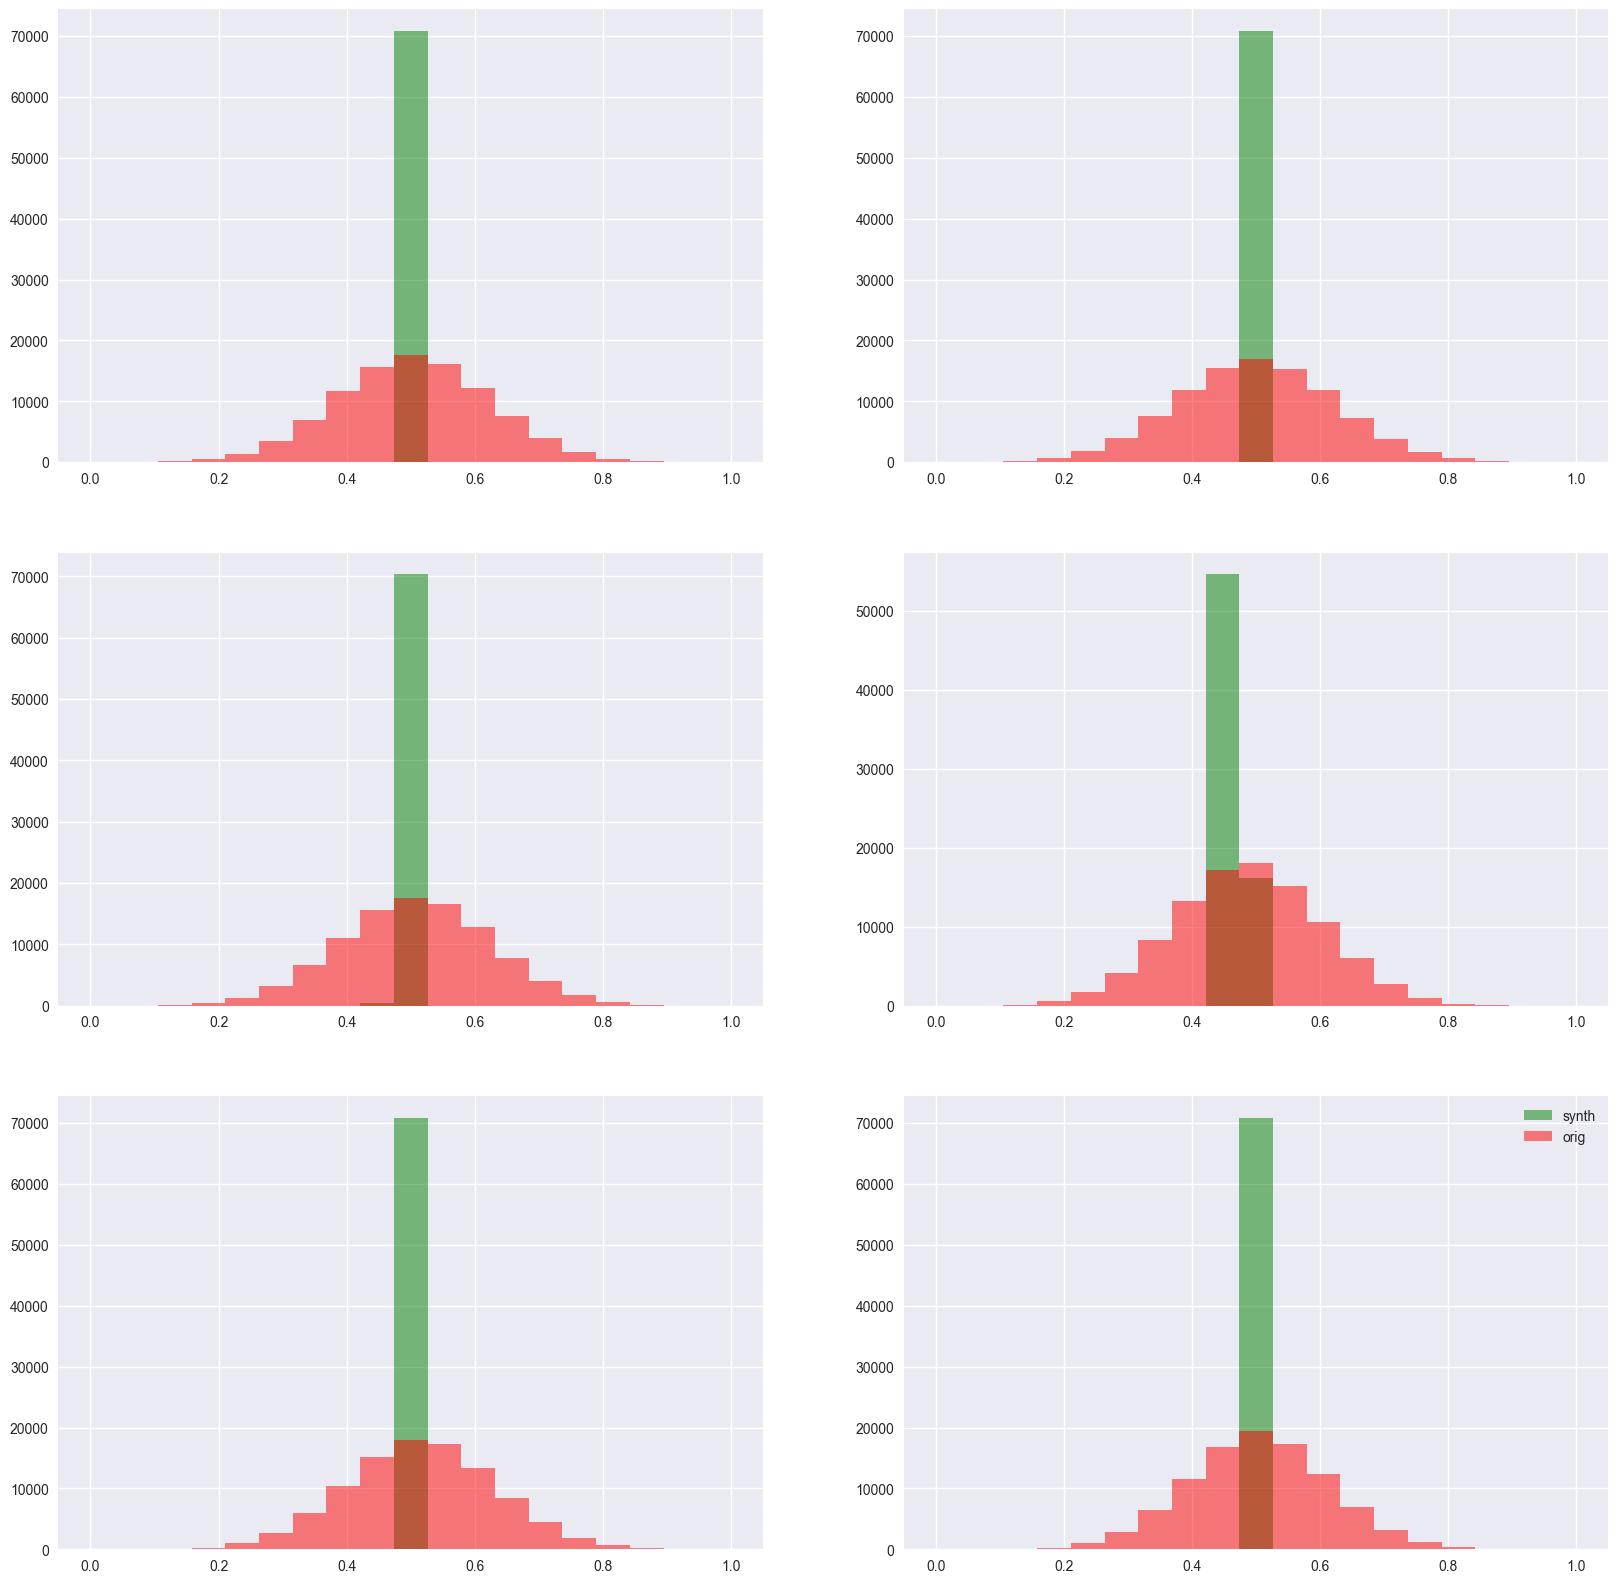

In [19]:

plot_hist(edges.drop(['start', 'end'], axis=1), lstm_edges.drop(['src', 'dst'], axis=1))


/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/metrics/distribution_metrics.py:140: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


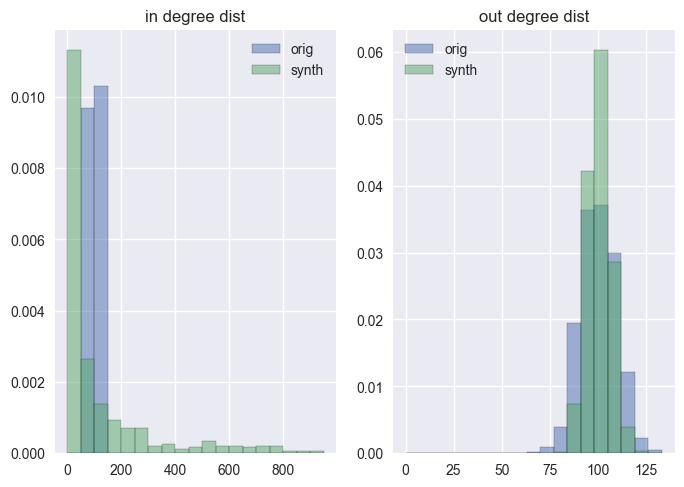

In [7]:
edm = EdgeDistributionMetrics(edges, mlp_edges)
edm.plot_degree_dst()

# Experiment 2 LSTM vs MLP using DDPM

Category dims K: [0]
Total number of dim in: 72
{'is_y_cond': False, 'num_classes': 1, 'rtdl_params': {'d_layers': [256, 256], 'dropout': 0.1}, 'd_in': 72}
 Generated 2048 out of 2000 = 102.4(1000, 72)Sum: 0.1724 val:0.067827656865119935


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/pandas/io/parquet.py:189: UserWarning: The DataFrame has column names of mixed type. They will be converted to strings and not roundtrip correctly.
  table = self.api.Table.from_pandas(df, **from_pandas_kwargs)


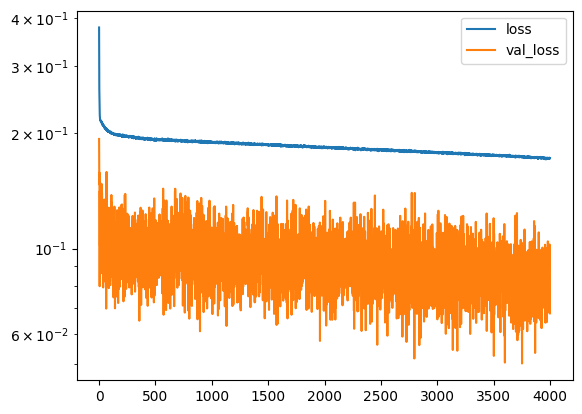

In [6]:
orchestrator = Orchestrator(folder)
orchestrator.train_node_synthesizer()
orchestrator.sample_node_synthesizer()
tmp = pd.read_parquet(folder + orchestrator.config['synth_nodes'])
# tmp.to_parquet(folder = "synth_nodes_ddpm.parquet")
print(tmp.shape)
# 0.1831 + 533 -> 300.000 steps
# 0.1 # 275 ->lr 0.01
# 0.1 342 -> 6e5 steps
# 432 -> 10K time steps / 10K steps
# 414 -> 10K time steps / 20K steps
# 1000 -> 256 dim

In [7]:
tmp = pd.read_parquet(folder + orchestrator.config['synth_nodes'])
tmp.to_parquet(folder + "synth_nodes_ddpm.parquet")
print(tmp.shape)

(1000, 72)


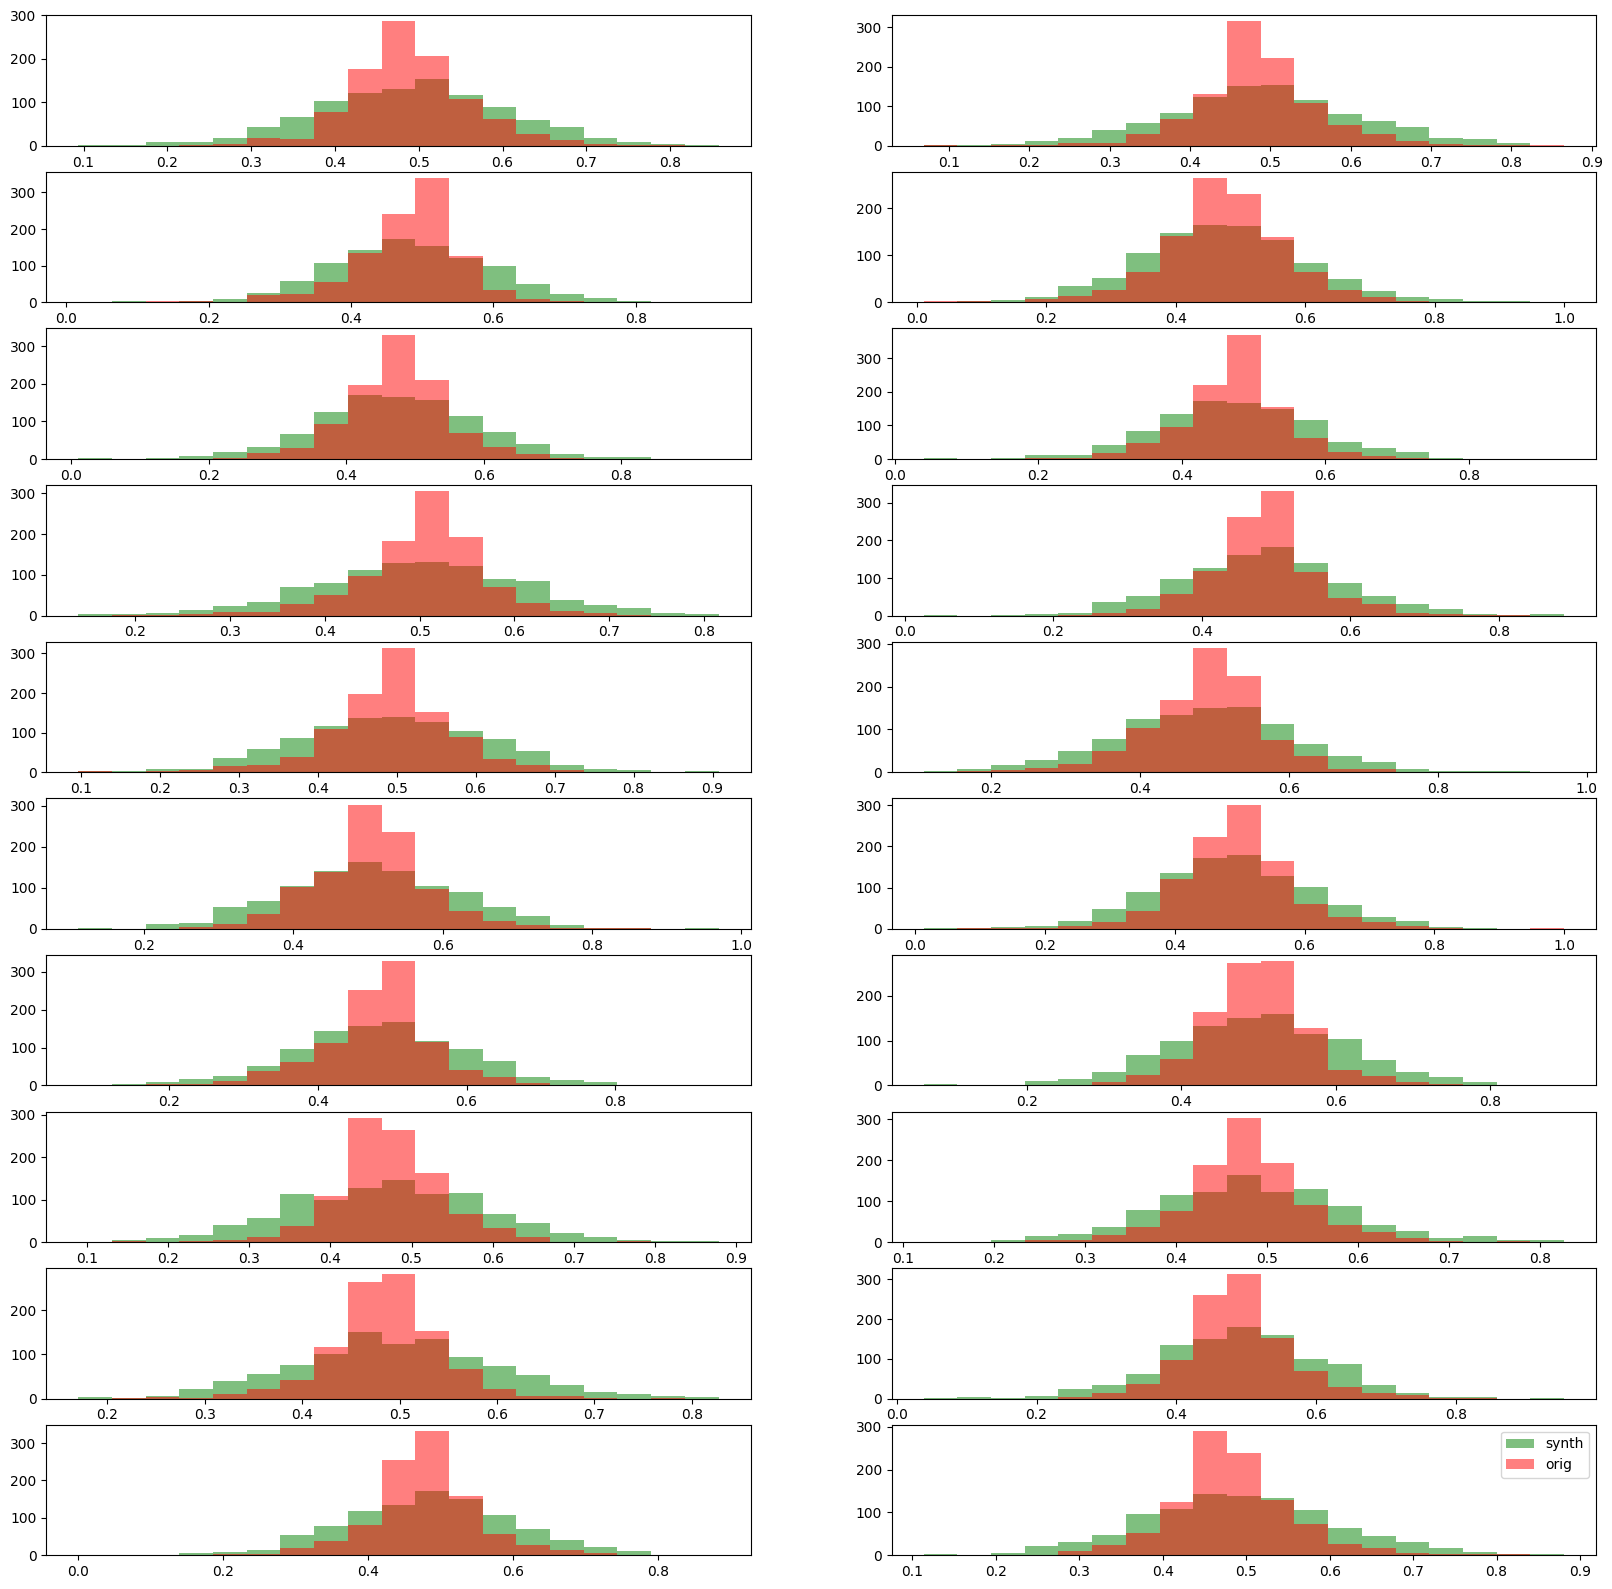

In [8]:
# check quality of synthetic nodes
node_df = orchestrator._load_nodes()
embed_norm = orchestrator._load_normalized_embed()
synth_nodes = orchestrator._load_synthetic_nodes()
x_data = embed_norm.join(node_df, how='inner')
plot_hist(x_data, synth_nodes, end=20)

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


  0%|          | 0/99549 [00:00<?, ?it/s]

Number of components, 130


/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/torch/nn/modules/rnn.py:82: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.1 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


  0%|          | 0/8000 [00:00<?, ?it/s]

  0%|          | 0/257 [00:00<?, ?it/s]

 7680 / 8000, epoch:99 loss=4.9087629318237305, val_loss: 5.3314704895019535

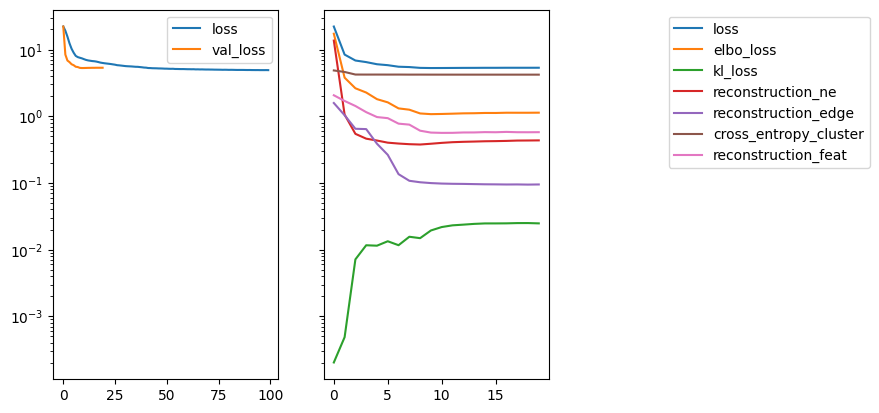

In [47]:
#train LSTM and sample edges
loss_dict = orchestrator.train_lstm()
orchestrator.create_synthetic_walks(
    synthesizer=orchestrator.lstm_controller,
    synth_node_file_name=folder + "synth_nodes_ddpm.parquet",
    target_cnt=200000, map_real_time=False
)

# rename synth walks
obj = pickle.load(open(folder + 'synth_walks.pickle', 'rb'))
pickle.dump(obj, open(folder + 'synth_walks_lstm_ddpm.pickle', 'wb'))

# create synth graph
orchestrator.generate_synth_graph(synth_nodes_name = folder + "synth_nodes_ddpm.parquet")
tmp = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
tmp.to_parquet(folder + 'synth_graph/node_attributes_lstm_ddpm.parquet')
tmp = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
tmp.to_parquet(folder + 'synth_graph/adjacency_lstm_ddpm.parquet')

/Users/tonpoppe/anaconda3/envs/tg_geo/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


 epoch 100/100 train loss 4.805886068127372 val loss: 4.7703047752380375

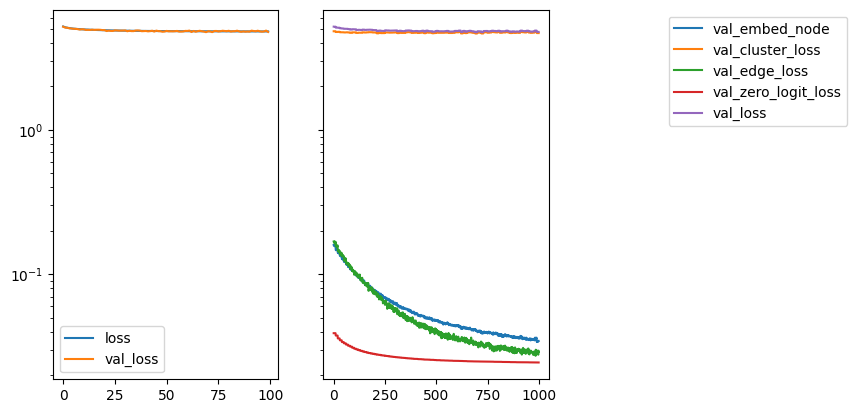

In [48]:
#train MLP and sample edges
loss_dict = orchestrator.train_graphsyntesizer2()
orchestrator.create_synthetic_walks(
    synthesizer=orchestrator.graphsynthesizer2,
    target_cnt=200000, synth_node_file_name=folder + "synth_nodes_ddpm.parquet", map_real_time=False
)

# rename synth walks
obj = pickle.load(open(folder + 'synth_walks.pickle', 'rb'))
pickle.dump(obj, open(folder + 'synth_walks_mlp_ddpm.pickle', 'wb'))

# create synth graph
orchestrator.generate_synth_graph(synth_nodes_name = folder + "synth_nodes_ddpm.parquet")
tmp = pd.read_parquet(folder + 'synth_graph/node_attributes.parquet')
tmp.to_parquet(folder + 'synth_graph/node_attributes_mlp_ddpm.parquet')
tmp = pd.read_parquet(folder + 'synth_graph/adjacency.parquet')
tmp.to_parquet(folder + 'synth_graph/adjacency_mlp_ddpm.parquet')

LSTM: orig has (99549, 9) format and synth edges (21004, 9)
MLP: orig has (99549, 9) format and synth edges (96560, 9)


/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/metrics/distribution_metrics.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()
/Users/tonpoppe/workspace/tigger_adj_rep/tigger_adj/tigger_package/metrics/distribution_metrics.py:183: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


,type,metric,name,LSTM,MLP
0,node_attributes,Wasserstein_distance,attr0,0.032098,0.032098
1,node_attributes,Wasserstein_distance,attr1,0.026278,0.026278
2,node_attributes,Wasserstein_distance,attr2,0.022429,0.022429
3,node_attributes,Wasserstein_distance,attr3,0.023901,0.023901
4,node_attributes,Wasserstein_distance,attr4,0.026617,0.026617
5,node_attributes,Wasserstein_distance,attr5,0.020827,0.020827
6,node_attributes,Wasserstein_distance,attr6,0.021829,0.021829
7,node_attributes,Wasserstein_distance,attr7,0.017829,0.017829
8,edge_attributes,Wasserstein_distance,edge_att0,0.090253,0.011301
9,edge_attributes,Wasserstein_distance,edge_att1,0.095490,0.008841


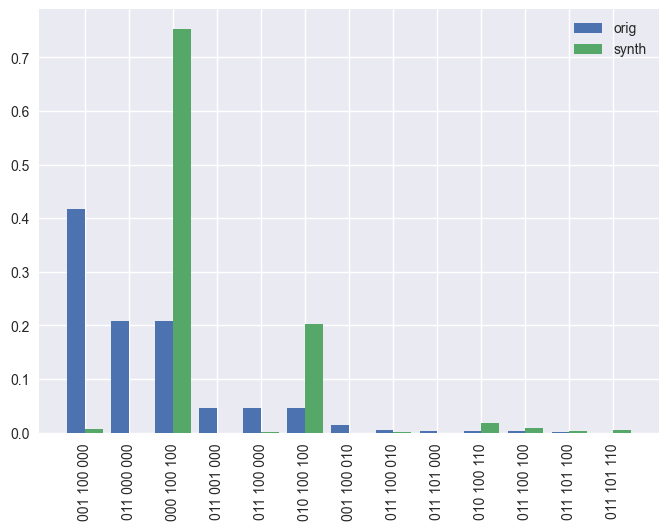

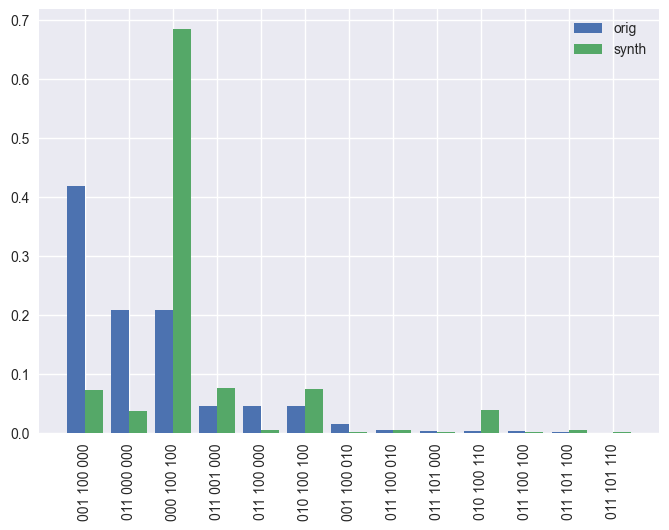

In [51]:
#assess quality of synthegraph
nodes = orchestrator._load_nodes()
edges = orchestrator._load_edges()

lstm_nodes = pd.read_parquet(folder + 'synth_graph/node_attributes_lstm_ddpm.parquet')
lstm_edges = pd.read_parquet(folder + 'synth_graph/adjacency_lstm_ddpm.parquet')
print(f"LSTM: orig has {edges.shape} format and synth edges {lstm_edges.shape}")

mlp_nodes = pd.read_parquet(folder + 'synth_graph/node_attributes_mlp_ddpm.parquet')
mlp_edges = pd.read_parquet(folder + 'synth_graph/adjacency_mlp_ddpm.parquet')
print(f"MLP: orig has {edges.shape} format and synth edges {mlp_edges.shape}")  
 
lstm_results = compare_metrics(nodes, edges, lstm_nodes, lstm_edges, "LSTM")
mlp_results = compare_metrics(nodes, edges, mlp_nodes, mlp_edges, "MLP")
results = lstm_results.merge(mlp_results, on=['name', 'type', 'metric'])
results[['type', 'metric', 'name', 'LSTM', 'MLP']]

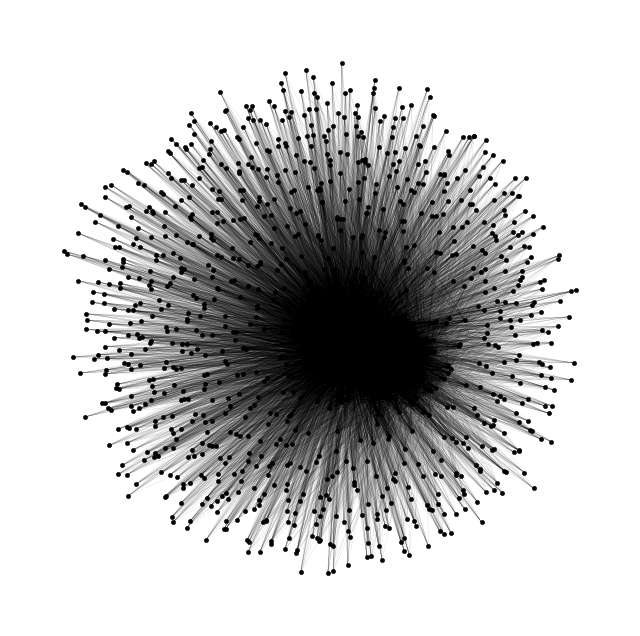

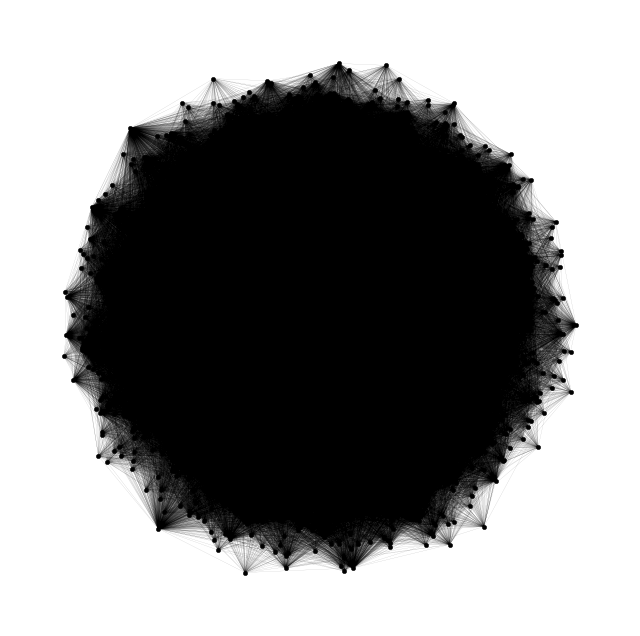

In [52]:
#plot graphs
plot_adj_matrix(lstm_edges)
plot_adj_matrix(mlp_edges)

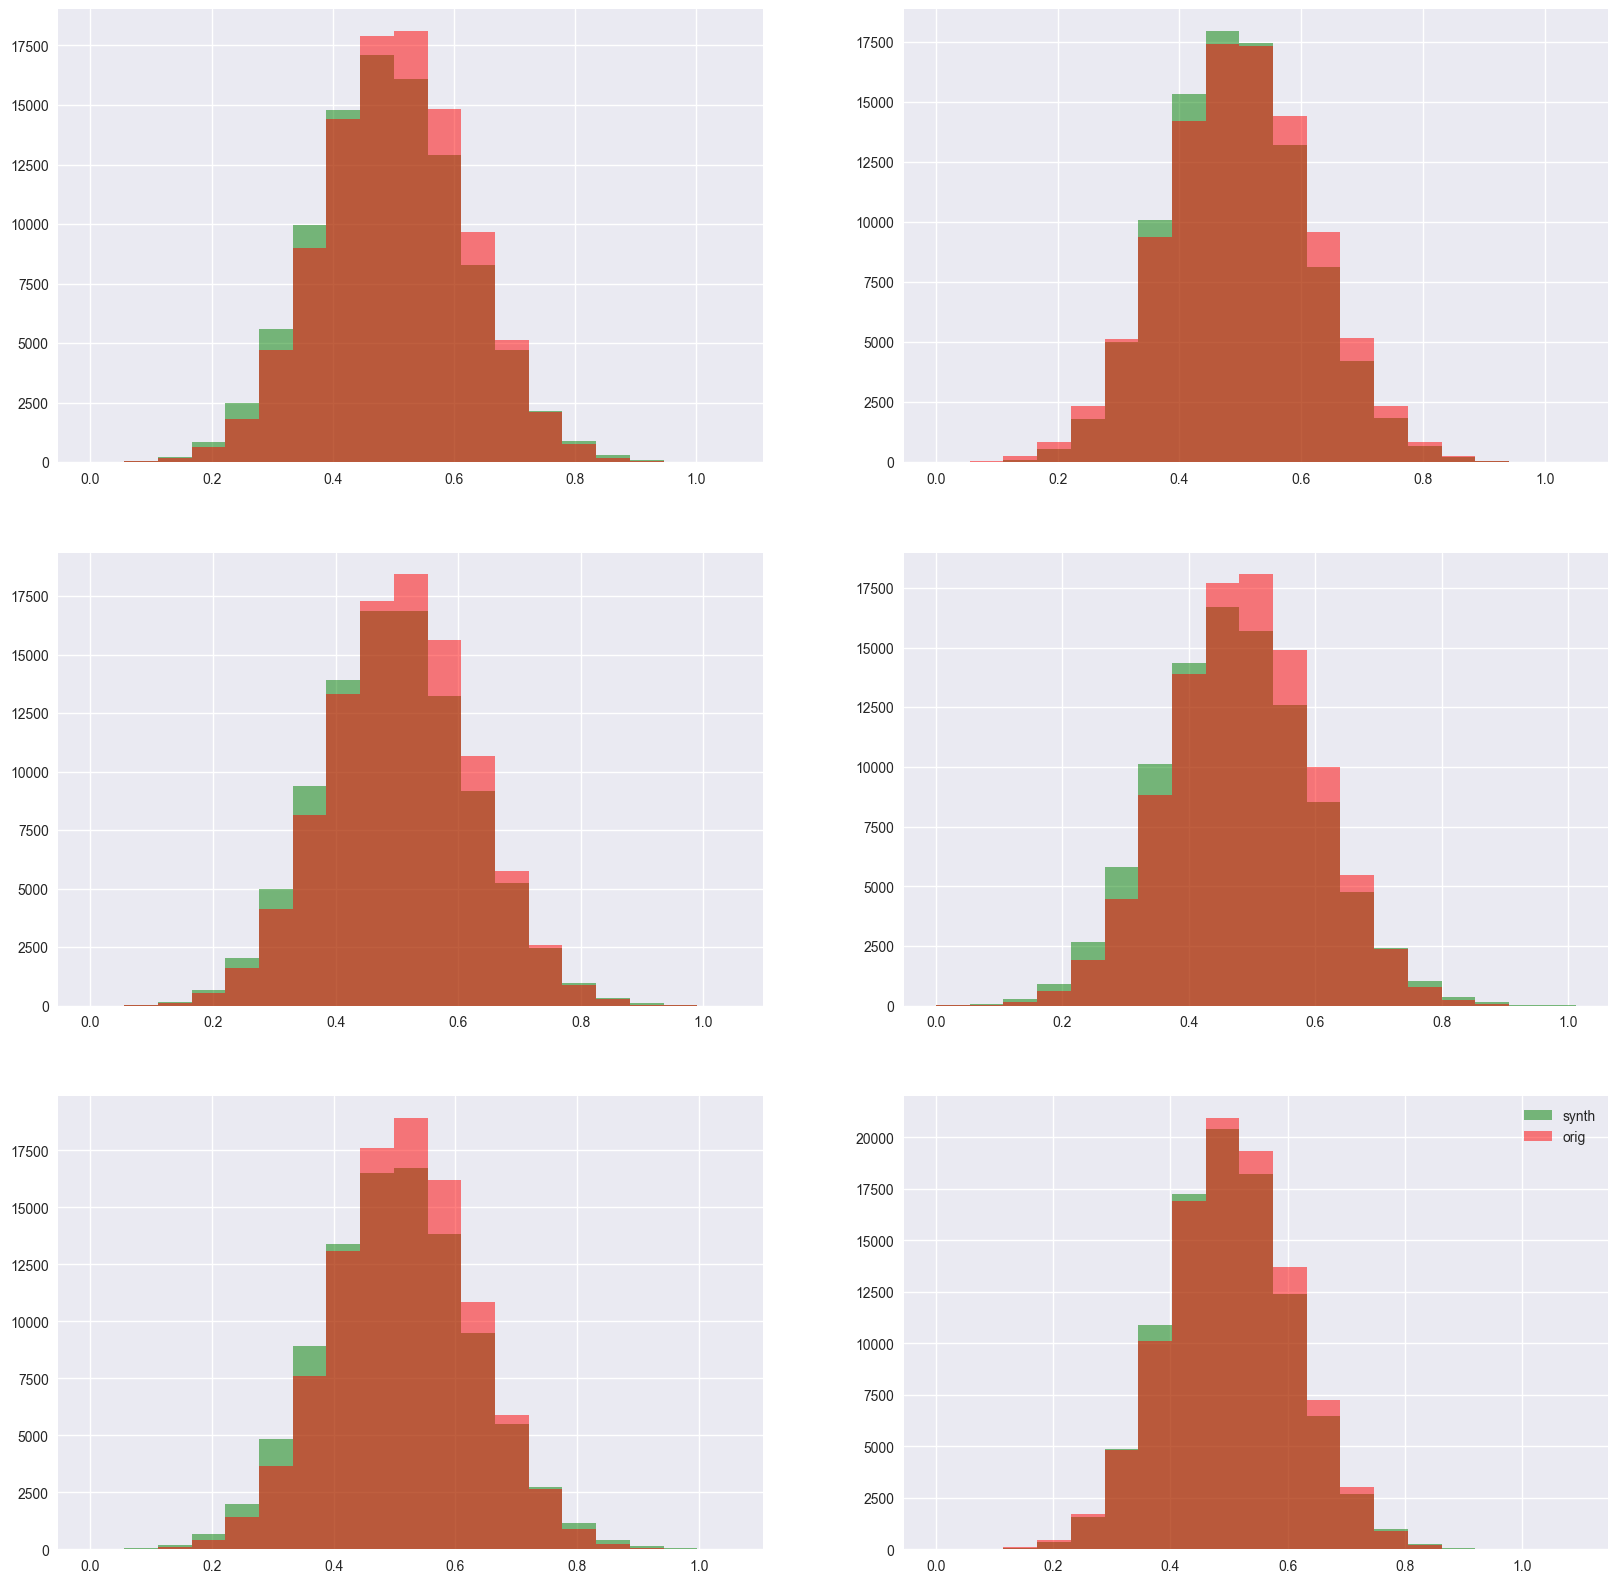

In [53]:
from tigger_package.tools import plot_hist 
plot_hist(edges.drop(['start', 'end'], axis=1), mlp_edges.drop(['src', 'dst'], axis=1))